# Predicción de la tasa de cancelación de los clientes de una empresa de telecomunicaciones

## Introducción

El operador de telecomunicaciones Interconnect busca predecir su tasa de cancelación de clientes con el objetivo de retener a aquellos usuarios que podrían estar considerando dejar el servicio. Si se identifica que un cliente tiene la intención de cancelar, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado una variedad de datos personales de sus clientes, incluyendo información relacionada con sus planes y contratos.

### Descripción del proyecto

El proyecto se estructura en las siguientes partes:

- __Inicialización__: Importar y describir los conjuntos de datos.


- __Preprocesamiento de datos__:  Limpiar y preparar los datos para el análisis, abordando la trasnformación de las variables al tipo de dato correcto, la eliminación de valores duplicados y la gestión de valores nulos.


- __Análisis Exploratorio de Datos (EDA)__: Realizar una revisón de los datos para identificar patrones, tendencias, y posibles desequilibrios en las clases.


- __Preparación de los datos para el modelo__:Estandarizar las variables numéricas y aplicar técnicas de codificación. Dividir los datos en conjuntos de entrenamiento y prueba. Aplicar técnica para equilibrar las clases y seleccionar variables.


- __Modelado, entrenamiento y seleccion del mejor modelo__: Establecer los algoritmos que se emplearán como regresión logística, random forest y LGMB Clasifier. Entrenar los modelos en el conjunto de entrenamiento y evaluar su rendimiento utilizando la métrica AUC.


- __Explicación de los resultados__: Dar conclusiones.



## Inicialización

In [1]:
# Cargar bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMClassifier

In [2]:
# Cargar archivos archivos csv
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv') 
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
# Unificar los conjuntos de datos
df = pd.merge(contract, personal, on='customerID')
df = pd.merge(df, internet, on='customerID', how='left')
df = pd.merge(df, phone, on='customerID', how='left')

Cada archivo contiene la columna `customerID` que sirve como identificador único de cada cliente, el cual se empleó para unificar todos los conjuntos.

## Preprocesamiento de datos

### Transformación y creación de variables

In [4]:
# Convertir 'BeginDate', 'EndDate' a tipo fecha
df['BeginDate'] = pd.to_datetime(df['BeginDate'], errors='coerce')
df['EndDate'] = pd.to_datetime(df['EndDate'], errors='coerce')

In [5]:
# Crear la variable objetivo "Churn", 1 el cliente ha cancelado, 0 el cliente no ha cancelado
df['Churn'] = (df['EndDate'].notnull()) * 1

In [6]:
# Reemplazamos los valores nules de "EndDate" por '2020-02-01'
df['EndDate'] = df['EndDate'].fillna('2020-02-01')
df['EndDate'] = pd.to_datetime(df['EndDate'], errors='coerce')

In [7]:
# Convertir 'TotalCharges' a tipo númerico
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [8]:
# Craer variables "Month", "Day" y "Weekday" a partir de la variable "BeginDate"
df['BeginMonth'] = df['BeginDate'].dt.month
df['BeginDay'] = df['BeginDate'].dt.day
df['BeginWeekday'] = df['BeginDate'].dt.weekday

In [9]:
# Crear nuevas características basadas en las fechas incial y final
df['TenureMonth'] = (df['EndDate'] - df['BeginDate']).dt.days / 30
df['TenureDays'] = (df['EndDate'] - df['BeginDate']).dt.days
df['Tenureyear'] = df['EndDate'].dt.year - df['BeginDate'].dt.year

### Valores nulos e imputación

In [10]:
# Identificar la cantidad de valores nulos
df.isna().sum().sort_values(ascending=False)

OnlineSecurity      1526
DeviceProtection    1526
StreamingMovies     1526
StreamingTV         1526
InternetService     1526
TechSupport         1526
OnlineBackup        1526
MultipleLines        682
TotalCharges          11
TenureDays             0
TenureMonth            0
BeginWeekday           0
BeginDay               0
BeginMonth             0
Churn                  0
customerID             0
BeginDate              0
Dependents             0
Partner                0
SeniorCitizen          0
gender                 0
MonthlyCharges         0
PaymentMethod          0
PaperlessBilling       0
Type                   0
EndDate                0
Tenureyear             0
dtype: int64

In [11]:
 # Imputar con 0 para "TotalCharges"
df["TotalCharges"] = df["TotalCharges"].fillna(0) 

In [12]:
# Establecemos las variables que serán rellenadas con 'No'
na_var = df[['OnlineSecurity', 'OnlineBackup', 'StreamingMovies', 'StreamingTV',
       'TechSupport', 'InternetService', 'DeviceProtection', 'MultipleLines']]

# Llenar valores nulos con "No"
for col in na_var:
    df[col] = df[col].fillna('No')

In [13]:
# Comprobar que ya no existen valores nulos
df.isna().sum().sort_values(ascending=False)

customerID          0
OnlineBackup        0
TenureDays          0
TenureMonth         0
BeginWeekday        0
BeginDay            0
BeginMonth          0
Churn               0
MultipleLines       0
StreamingMovies     0
StreamingTV         0
TechSupport         0
DeviceProtection    0
OnlineSecurity      0
BeginDate           0
InternetService     0
Dependents          0
Partner             0
SeniorCitizen       0
gender              0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Type                0
EndDate             0
Tenureyear          0
dtype: int64

El preprocesamiento de datos permitió preparar el conjunto de datos para el análisis posterior. Se realizaron conversiones de formato, se crearon nuevas variables relevantes y se trataron los valores faltantes mediante técnicas de imputación justificadas.

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b>
<p>El preprocesamiento de datos fue ejecutado de manera minuciosa, abordando correctamente la conversión de formatos y la creación de variables relevantes. Has demostrado una excelente atención al detalle al manejar valores nulos y asegurarte de que los datos estén listos para el análisis. La creación de nuevas características basadas en las fechas inicial y final es un buen ejemplo de cómo enriquecer el conjunto de datos para mejorar el modelado.</p>
</div>


## Análsis exploratorio de datos


### Variables categóricas y variables objetivo

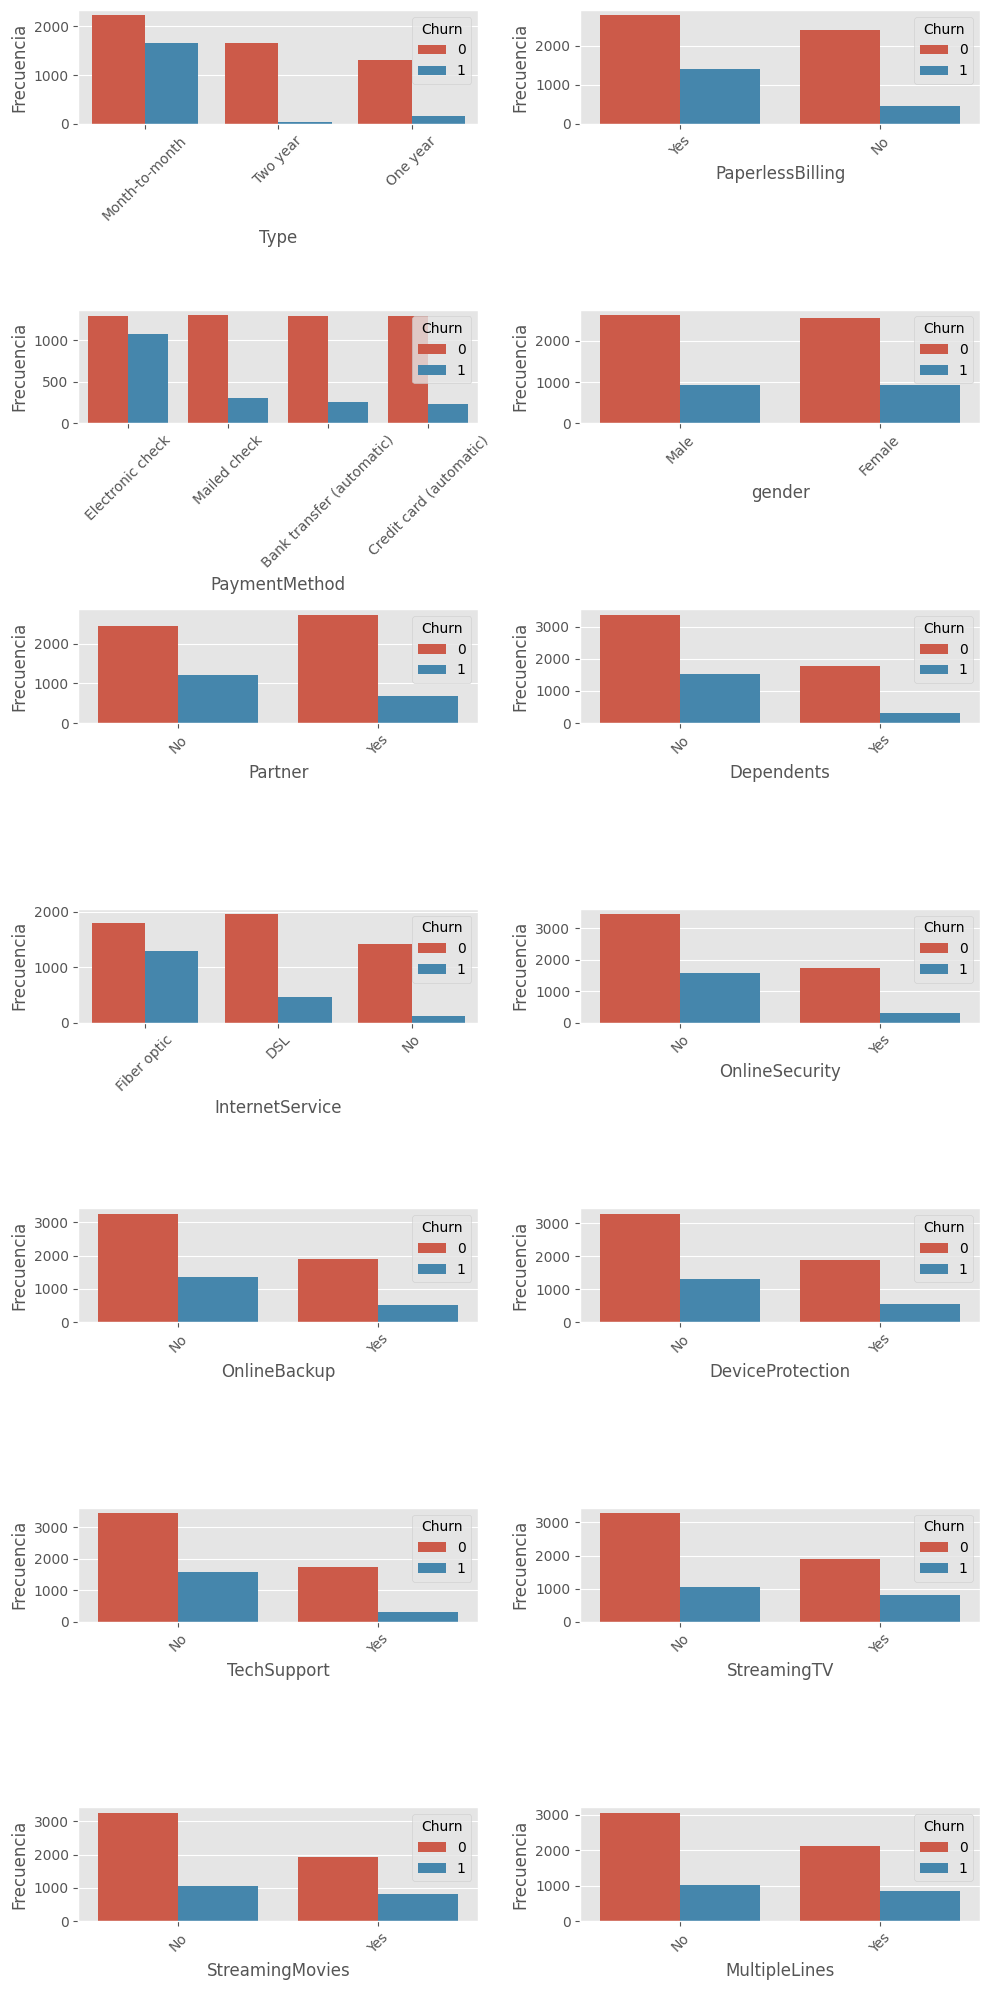

In [14]:
# Variables categóricas
var_object = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender',
       'Partner', 'Dependents', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'MultipleLines']

# Crear la figura y los ejes
fig, axes = plt.subplots(7, 2, figsize=(10, 20))
axes = axes.flatten()

# Crear gráficos de las variables cualtitativas
for i, col in enumerate(var_object):
    sns.countplot(x=col, data=df, ax=axes[i], order=df[col].value_counts().index, hue="Churn")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    axes[i].set_ylabel('Número de clientes') 

# Ajustar los espacios entre subgráficos
plt.tight_layout()
plt.show()

### Variables numéricas y variable objetivo

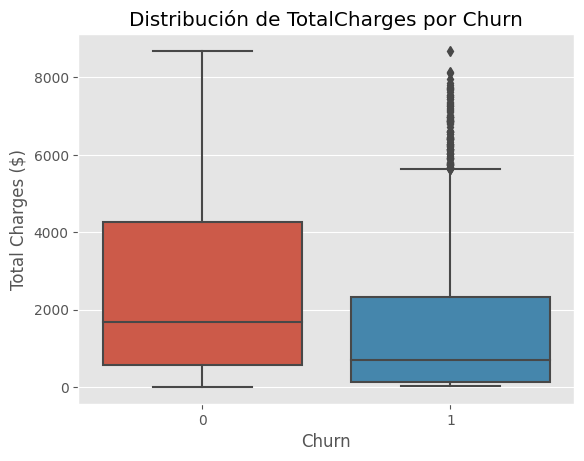

In [55]:
# Diagrama de caja y bigotes para TotalCharges por Churn
sns.boxplot(x='Churn', y='TotalCharges', data=df)
plt.title('Distribución de TotalCharges por Churn')
plt.xlabel('Churn')
plt.ylabel('Total Charges ($)');

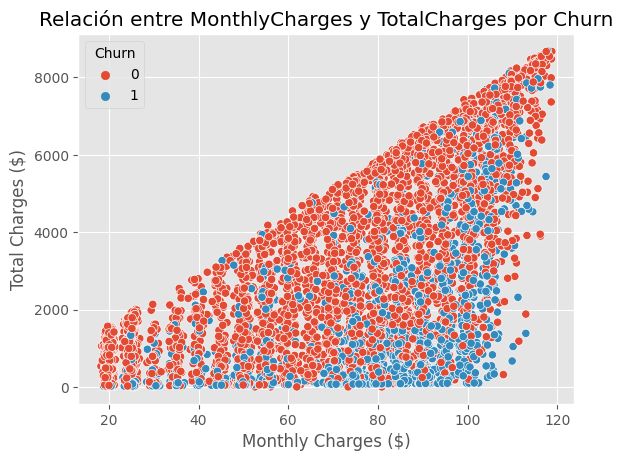

In [56]:
# Diagrama de dispersión para MonthlyCharges vs TotalCharges, coloreado por Churn
sns.scatterplot(x='MonthlyCharges', y='TotalCharges', hue='Churn', data=df)
plt.title('Relación entre MonthlyCharges y TotalCharges por Churn')
plt.xlabel('Monthly Charges ($)')
plt.ylabel('Total Charges ($)');

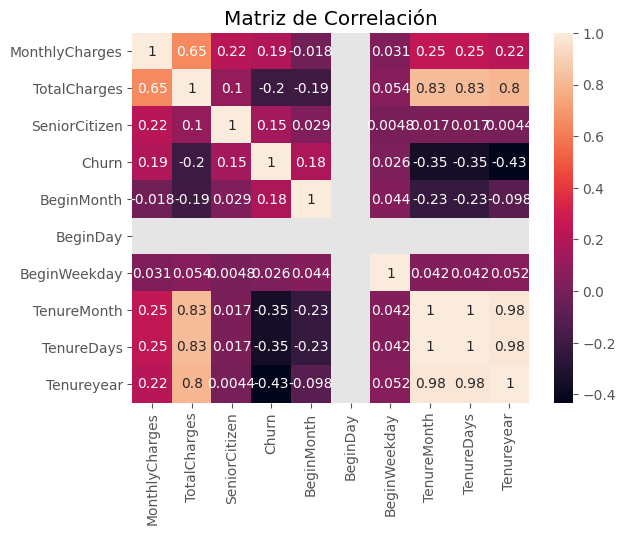

In [58]:
# Matriz de correlación
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.title('Matriz de Correlación');

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b>
    
<p>¡Excelente trabajo al incluir la matriz de correlación en tu análisis exploratorio de datos! Esta visualización proporciona una visión clara de las relaciones entre las variables, lo que es crucial para entender cómo interactúan entre sí.</p>

<p>Además, la correlación negativa entre `Churn` y `TenureMonth` es un hallazgo importante, ya que indica que los clientes con una mayor duración de permanencia tienen menos probabilidades de cancelar, lo cual es valioso para la construcción de modelos predictivos. Sin embargo, también es importante tener en cuenta las correlaciones más bajas o insignificantes, como entre `Churn` y `MonthlyCharges`, lo que puede sugerir que otras variables podrían ser más relevantes en la predicción de la cancelación de clientes.</p>


</div>


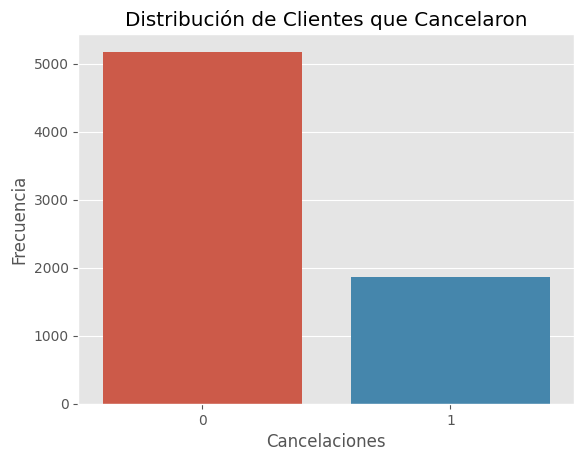

In [20]:
# Distribución de clientes que cancelaron
sns.countplot(x='Churn', data=df)
plt.title('Distribución de Churn')
plt.xlabel('Churn')
plt.ylabel('Número de clientes');

Los gráficos de conteo muestran que ciertas características de los clientes están asociadas a una mayor probabilidad de cancelación del servicio como la variable tipo de contrato. Es importante mencionar que existe un desbalance en la variable objetivo "Churn", esto puede afectar el desempeño de los modelos de clasificación y requerir técnicas de balanceo de datos. Además, el diagrama de caja muestra si existe una diferencia significativa en los cargos totales entre los clientes que se quedan y los que se van.

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b>
<p>Tu análisis exploratorio de datos es muy completo y utiliza una variedad de visualizaciones efectivas para identificar patrones clave. Has logrado resaltar importantes asociaciones entre las características de los clientes y la probabilidad de cancelación, lo que es crucial para la construcción de modelos predictivos. La identificación del desbalance en la variable objetivo es especialmente importante y demuestra tu conciencia sobre cómo esto puede afectar el rendimiento de los modelos.</p>
</div>


## Preparación de los datos para el modelo

 ### One-hot-encoding y estandarización
 

In [21]:
# Codificación One-Hot
categorical_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner',
       'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines']
X_encoded = pd.get_dummies(df[categorical_features])

In [27]:
# Estandarizar las características numéricas
numerical_features = ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'BeginMonth', 'BeginDay', 
                      'BeginWeekday', 'TenureMonth', 'TenureDays', 'Tenureyear']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numerical_features])

In [28]:
X_scaled = pd.DataFrame(X_scaled, columns = numerical_features)

### Equilibrio de clases y selección de variables

In [29]:
# Mostrar la proporción de cada clase en la variable objetivo
df['Churn'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: Churn, dtype: float64

In [30]:
# Combinar con características numéricas
X = pd.concat([X_encoded, X_scaled], axis=1)
y = df['Churn']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [33]:
# Enfoque para corregir el desequelibrio: sobremuestreo
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=54321)
    return features_upsampled, target_upsampled

In [34]:
# Realizar el sobremuestreo de los datos de entrenamiento con un factor de repetición de 3
X_upsampled, y_upsampled = upsample(
    X_train, y_train, 3
)

In [35]:
# Mostrar la proporción de clases después del sobremuestreo
y_upsampled.value_counts(normalize=True)

1    0.522554
0    0.477446
Name: Churn, dtype: float64

In [36]:
# Selección de características con Chi-squared para variables categóricas
chi2_selector = SelectKBest(chi2, k=8)  # Seleccionar las 8 mejores características
X_train_chi2 = chi2_selector.fit_transform(X_upsampled[X_encoded.columns], y_upsampled)
selected_categorical_features = X_encoded.columns[chi2_selector.get_support()]

In [37]:
# Seleccionar características con Lasso para variables numéricas
lasso_selector = SelectFromModel(Lasso(alpha=0.005))
lasso_selector.fit(X_upsampled[numerical_features], y_upsampled)

selected_features = lasso_selector.get_support()

selected_numerical_features = [feature for feature, is_selected in zip(numerical_features, selected_features) if is_selected]
selected_numerical_features = list(selected_numerical_features)

In [38]:
# Combinar las características seleccionadas
selected_features = list(selected_categorical_features) + selected_numerical_features
selected_features

['Type_Month-to-month',
 'Type_One year',
 'Type_Two year',
 'PaperlessBilling_No',
 'PaymentMethod_Electronic check',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_Yes',
 'MonthlyCharges',
 'SeniorCitizen',
 'BeginMonth',
 'BeginWeekday',
 'TenureMonth',
 'Tenureyear']

In [39]:
# Dividir los datos en entrenamiento y prueba
X_train, y_train = X_train[selected_features], y_train
X_test = X_test[selected_features]

Se aplicó la codificación One-Hot-Encoding usando para crear variables binarias que representen cada categoría posible para las variables categóricas y la estadarización para las variables numéricas. Asimismo, para corregir el desequilibrio de clases, se implementó la técnica de sobremuestreo con la finalidad de seleccinarlas variables más relevantes para mejorar la eficiencia de los modelos que se implementarán en la siguiente sección.

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b>
<p>Excelente trabajo en la preparación de los datos para el modelado. La implementación de la codificación One-Hot para las variables categóricas y la estandarización de las variables numéricas asegura que los datos estén en un formato óptimo para el modelado. Además, la aplicación de técnicas de sobremuestreo para corregir el desequilibrio de clases es un paso crucial que demuestra una comprensión avanzada de los desafíos en el modelado de datos desbalanceados. También, la selección de características utilizando Chi-squared y Lasso es una buena práctica para reducir la dimensionalidad y mejorar la eficiencia del modelo. ¡Continúa así!</p>
</div>


## Modelado, entrenamiento y seleccion del mejor modelo:

###  Procedimiento de evaluación¶

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [40]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    """
    Evalúa el rendimiento de un modelo de clasificación utilizando diversas métricas y visualizaciones.

    Parámetros:
    - model: modelo de clasificación entrenado.
    - train_features: características del conjunto de entrenamiento.
    - train_target: variable objetivo del conjunto de entrenamiento.
    - test_features: características del conjunto de prueba.
    - test_target: variable objetivo del conjunto de prueba.

    Salida:
    - Imprime un resumen de las métricas de evaluación y muestra visualizaciones.
    """

    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

### Modelo 1: Regresión logística

In [45]:
%%time

# Definir la búsqueda de hiperparámetros para Regresión Logística
parameters = {
     'penalty' : ['l1','l2'], 
     'solver'  : ['liblinear', 'saga'],
     'C'       : [0.1, 1.0],
     'fit_intercept':[True, False],
     'random_state' : [12345]
 }

# Realizamos la búsqueda de hiperparámetros
churn_lr = GridSearchCV(LogisticRegression(random_state=12345),
                       param_grid=parameters,
                       scoring='f1',
                      cv=3
                       )

# Entrenamos el modelo 
churn_lr.fit(X_train, y_train)

CPU times: user 2.26 s, sys: 2.61 s, total: 4.86 s
Wall time: 4.85 s


GridSearchCV(cv=3, estimator=LogisticRegression(random_state=12345),
             param_grid={'C': [0.1, 1.0], 'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2'], 'random_state': [12345],
                         'solver': ['liblinear', 'saga']},
             scoring='f1')

In [46]:
# Mostramos los mejores parámetros encontrados
best_params_1 = churn_lr.best_params_
best_f1_1 = churn_lr.best_score_
print(f'Mejores hiperparámetros: {best_params_1} | Mejor f1: {best_f1_1:.4f}')

Mejores hiperparámetros: {'C': 1.0, 'fit_intercept': False, 'penalty': 'l1', 'random_state': 12345, 'solver': 'liblinear'} | Mejor f1: 0.8409


           train  test
Exactitud   0.92  0.94
F1          0.84  0.87
APS         0.92  0.92
ROC AUC     0.95  0.95


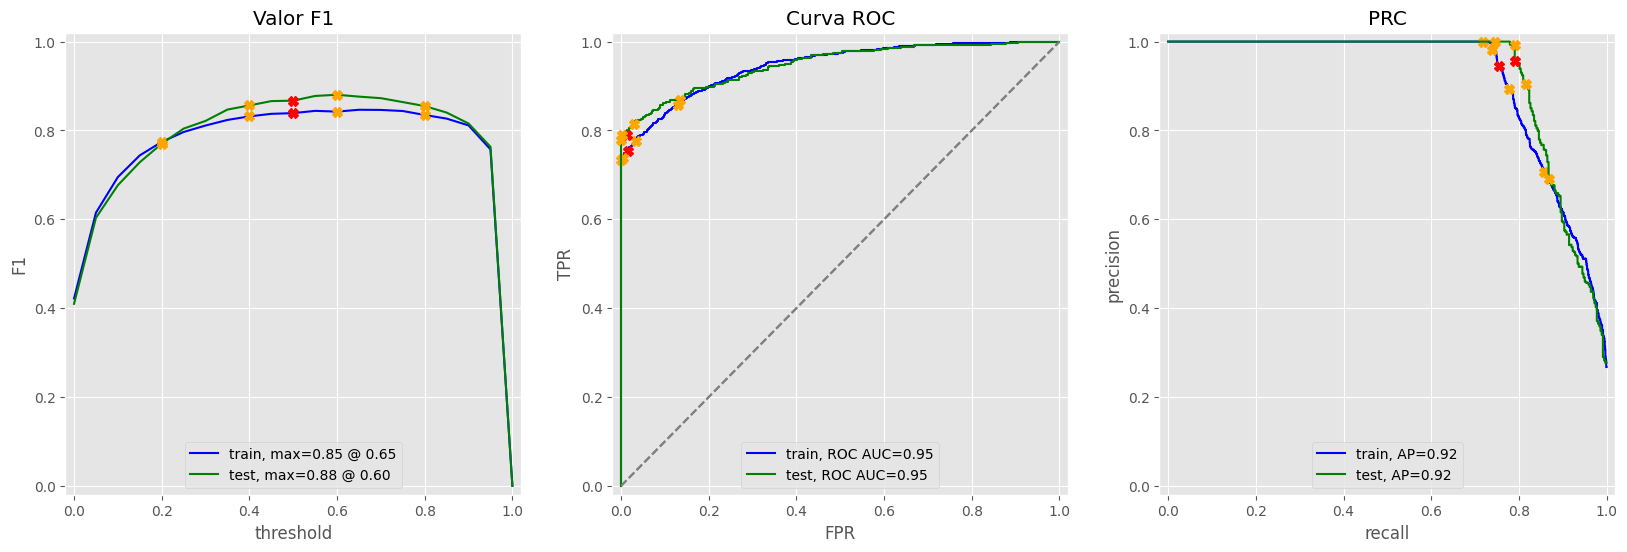

In [47]:
# Entrenamos nuestro primer modelo con los mejores hiperparámetros
model_1 = LogisticRegression(random_state=12345, solver='liblinear', penalty= 'l1', C= 1, fit_intercept=False)
model_1.fit(X_train, y_train)

# Evaluamos el modelo en el conjunto de prueba a través de la función evaluate_model
evaluate_model_1 = evaluate_model(model_1, X_train, y_train, X_test, y_test)
evaluate_model_1

### Modelo 2: Bosques aleatorios

In [48]:
%%time
# Establecemos los valores para determinar los mejores hiperparámetros de bosque aleatorio
parameters = {
    'criterion' : ['gini', 'entropy'],
    'n_estimators' : [10, 20, 40, 50],
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf' : [10, 12, 14],
    'random_state' : [12345]
}
        
                 
# Realizamos la búsqueda de hiperparámetros
churn_rf = GridSearchCV(RandomForestClassifier(random_state=12345),
                       param_grid=parameters,
                       scoring='f1',
                      cv=3
                       )

# Entrenamos el modelo 
churn_rf.fit(X_train, y_train)

CPU times: user 21.4 s, sys: 23.5 ms, total: 21.4 s
Wall time: 21.5 s


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10],
                         'min_samples_leaf': [10, 12, 14],
                         'n_estimators': [10, 20, 40, 50],
                         'random_state': [12345]},
             scoring='f1')

In [49]:
# Mostramos los mejores parámetros encontrados
best_params_2 = churn_rf.best_params_
best_f1_2 = churn_rf.best_score_
print(f'Mejores hiperparámetros: {best_params_2} | Mejor f1: {best_f1_2:.4f}')

Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 50, 'random_state': 12345} | Mejor f1: 0.7399


           train  test
Exactitud   0.90  0.88
F1          0.77  0.72
APS         0.90  0.84
ROC AUC     0.95  0.91


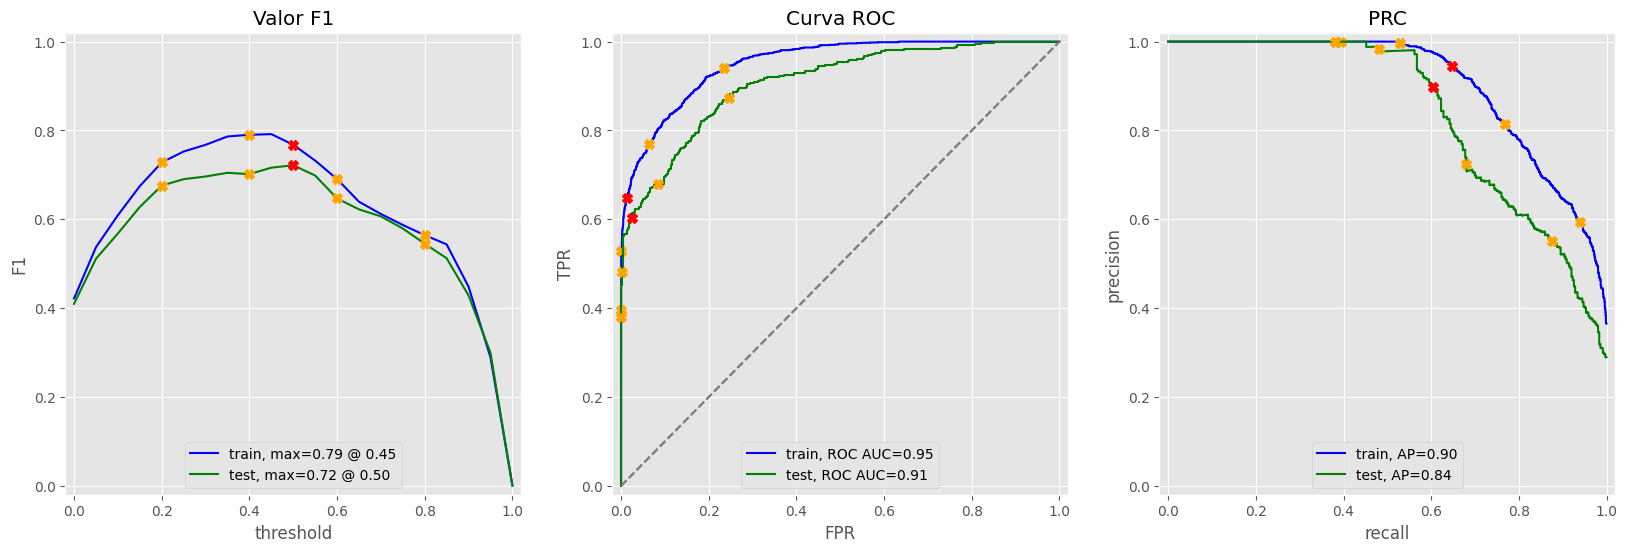

In [52]:
# Entrenamos nuestro primer modelo con los mejores hiperparámetros
model_2 = RandomForestClassifier(random_state=12345, criterion='entropy', max_depth=10, min_samples_leaf=10, 
                                 n_estimators=50)
model_2.fit(X_train, y_train)

# Evaluamos el modelo en el conjunto de prueba a través de la función evaluate_model
evaluate_model_2 = evaluate_model(model_2, X_train, y_train, X_test, y_test)
evaluate_model_2

### Modelo 3: LGBM

In [51]:
%%time

# Definir la búsqueda de hiperparámetros para LightGBM
parameters_lightgbm = {
    'objective': ['binary'],
    'num_leaves': [31, 40],
    'learning_rate': [0.1, 0.2],
    'random_state' : [12345]
}

# Realizar la búsqueda de hiperparámetros
spacy_lightgbm = GridSearchCV(
    LGBMClassifier(random_state=12345),
     param_grid=parameters_lightgbm,
     scoring='f1',
    cv=3
)

# Entrenar el modelo
spacy_lightgbm.fit(X_train, y_train)

CPU times: user 4min 27s, sys: 407 ms, total: 4min 27s
Wall time: 4min 28s


GridSearchCV(cv=3, estimator=LGBMClassifier(random_state=12345),
             param_grid={'learning_rate': [0.1, 0.2], 'num_leaves': [31, 40],
                         'objective': ['binary'], 'random_state': [12345]},
             scoring='f1')

In [53]:
# Mostramos los mejores parámetros encontrados
best_params_3 = spacy_lightgbm.best_params_
best_f1_3 = spacy_lightgbm.best_score_
print(f'Mejores hiperparámetros: {best_params_3} | Mejor f1: {best_f1_3:.4f}')

Mejores hiperparámetros: {'learning_rate': 0.2, 'num_leaves': 40, 'objective': 'binary', 'random_state': 12345} | Mejor f1: 0.9671


           train  test
Exactitud    1.0  0.99
F1           1.0  0.99
APS          1.0  1.00
ROC AUC      1.0  1.00


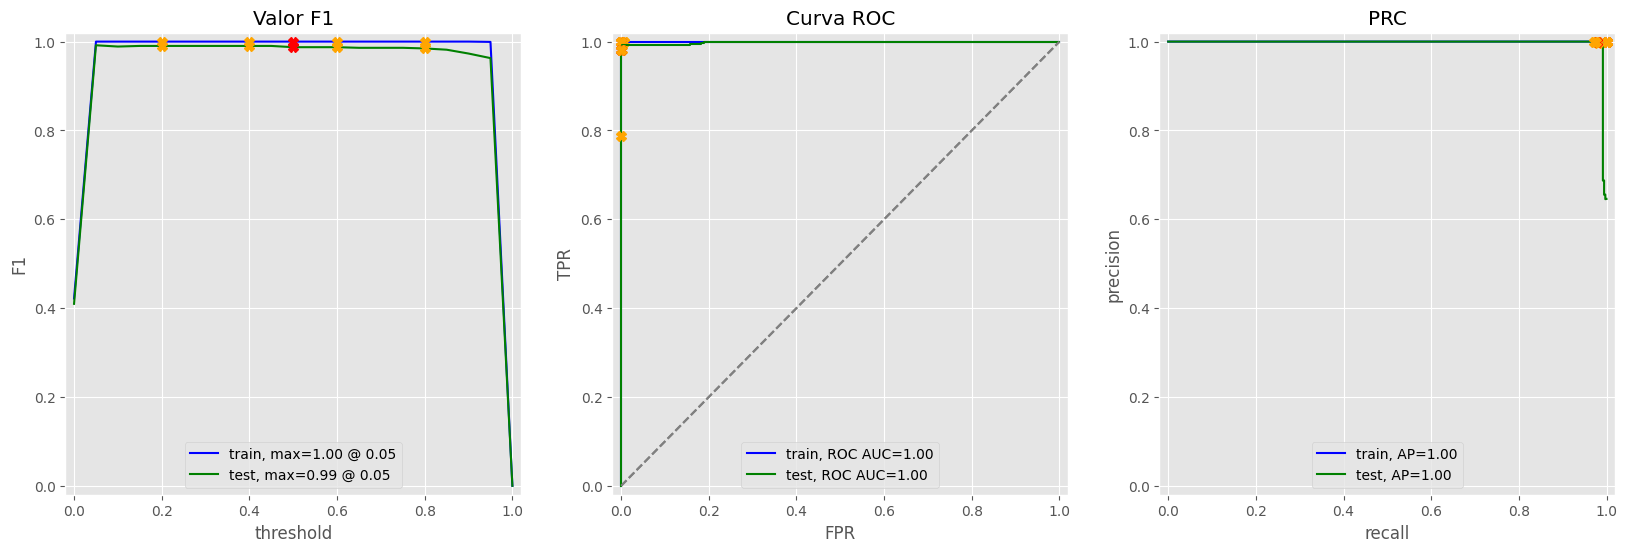

In [54]:
# Mejores hiperparámetros a nuestro modelo LGMBClassifier
model_3 = LGBMClassifier(learning_rate=0.2,
                             num_leaves=40, 
                             objective='binary',
                             random_state=12345)

# Entrenamos el modelo 
model_3.fit(X_train, y_train)

# Evaluamos el rendimiento del modelo con la función 'evalute_model'
evaluate_model_3 = evaluate_model(model_3, X_train, y_train, X_test, y_test)
evaluate_model_3

Basándonos en las métricas de evaluación, LightGBM (modelo 3) parece ser el modelo con mejor rendimiento general. Sin embargo, el hecho de que obtenga un F1 de 1.0 en ambos conjuntos de datos sugiere un posible sobreajuste. Por lo que se elige como mejor modelo la regresión logística (modelo 1) donde el AUC-ROC obtenido es 0.95, lo que indica un buen rendimiento ara clasificar correctamente cada clase.

## Conclusiones

- La regresión Logística fue seleccionado como el mejor modelo basado en el análisis de las métricas y considerando el riesgo de sobreajuste, con un AUC-ROC de 0.95 en el conjunto de prueba.
- Las variables relacionadas con el tipo de contrato, la forma de pago y el tiempo de permanencia del cliente son factores importantes a considerar para la predicción del churn.
- De esta forma, se pueden ofrecer descuentos o promociones especiales a los clientes identificados como de alto riesgo de churn, para disminuir la tasa de cancelación. 